<a href="https://colab.research.google.com/github/akitim/comptech-winter-school-2022_covid19-prediction/blob/main/COVID-19_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COVID-19_baseline.ipynb

In [ ]:
!git clone https://github.com/comptech-winter-school/covid19-prediction

Cloning into 'covid19-prediction'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 26 (delta 11), reused 10 (delta 6), pack-reused 0
Unpacking objects: 100% (26/26), done.
Checking out files: 100% (9/9), done.


In [8]:
# !git clone https://github.com/comptech-winter-school/covid19-prediction
path_v = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv'
vacc = pd.read_csv(path_v)
vacc.location.value_counts()

European Union                      421
High income                         421
Europe                              421
World                               421
Denmark                             420
Norway                              419
Latvia                              418
United States                       409
North America                       409
Canada                              408
China                               407
Russia                              407
Upper middle income                 407
Asia                                407
Israel                              403
Switzerland                         400
Liechtenstein                       400
Qatar                               400
Bahrain                             399
Costa Rica                          398
South America                       398
Mexico                              398
Chile                               397
Italy                               395
Czechia                             395


<h1>Библиотеки и функции</h1>

In [6]:
from pathlib import Path
import pandas as pd 
import numpy as np
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt
import sklearn

%matplotlib inline
pd.set_option('display.max_rows', 300)

In [ ]:
def get_plot(country_first, country_second):
    """Строит график для страны country_first и страны country_second"""
    s = [country_first]
    if country_second:
        s.append(country_second)
        
    for country in s:
        a = gr[gr["Country_Region"] == country]
        signal = (a["Confirmed"] - a["Confirmed"].shift(1)).to_numpy()
        signal = savgol_filter(signal, 51, 2)
        
        # model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
        # algo = rpt.Window(width=50, model=model).fit(signal)
        # result = algo.predict(n_bkps=10)
        
        plt.title(country)
        plt.plot(a.index, signal)
        plt.gcf().autofmt_xdate(rotation=90, ha='center')
        plt.show()
        

cache = {}
    
def get_new_cases(d, c):
    """Взятие новых кейсов из датафрейма d для страны c и их сглаживание фильтром"""
    c1 = cache.get(c)
    if not c1 is None:
        return c1
    
    new_v = d[d["Country_Region"] == c]["Confirmed"]
    c1 = (new_v - new_v.shift(1)).dropna()
    try:
        f = savgol_filter(c1.to_numpy(), 51, 2)
        c1 = pd.Series(f, index=new_v.index[:-1])
        cache[c] = c1
        return c1
    except ValueError as e:
        return pd.Series()

<h1>Взятие данных</h1>

In [ ]:
path = "covid19-prediction"
all_files = Path(path).glob("data*.csv") 

df = pd.concat(map(pd.read_csv, all_files));

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.head()

,Unnamed: 0,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,Incident_Rate,Case_Fatality_Ratio,Province/State,Country/Region,Last Update,Latitude,Longitude
0,1923,24047.0,Worcester,Maryland,US,2022-01-13 08:00:09,38.212743,-75.332000,6974.0,134.0,NaN,NaN,"Worcester, Maryland, US",NaN,NaN,13340.729972,1.921422,NaN,NaN,NaN,NaN,NaN
1,1924,25001.0,Barnstable,Massachusetts,US,2022-01-13 08:00:09,41.729806,-70.288543,28765.0,577.0,NaN,NaN,"Barnstable, Massachusetts, US",NaN,NaN,13505.328889,2.005910,NaN,NaN,NaN,NaN,NaN
2,1925,25003.0,Berkshire,Massachusetts,US,2022-01-13 08:00:09,42.374284,-73.205248,16345.0,351.0,NaN,NaN,"Berkshire, Massachusetts, US",NaN,NaN,13081.860674,2.147446,NaN,NaN,NaN,NaN,NaN
3,1926,25005.0,Bristol,Massachusetts,US,2022-01-13 08:00:09,41.792284,-71.108722,124746.0,2138.0,NaN,NaN,"Bristol, Massachusetts, US",NaN,NaN,22070.461433,1.713883,NaN,NaN,NaN,NaN,NaN
4,1927,NaN,Dukes and Nantucket,Massachusetts,US,2022-01-13 08:00:09,41.406747,-70.687635,5599.0,7.0,NaN,NaN,"Dukes and Nantucket, Massachusetts, US",NaN,NaN,19487.661411,0.125022,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2637010 entries, 0 to 527401
Data columns (total 22 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   FIPS                 float64
 2   Admin2               object 
 3   Province_State       object 
 4   Country_Region       object 
 5   Last_Update          object 
 6   Lat                  float64
 7   Long_                float64
 8   Confirmed            float64
 9   Deaths               float64
 10  Recovered            float64
 11  Active               float64
 12  Combined_Key         object 
 13  Incidence_Rate       float64
 14  Case-Fatality_Ratio  float64
 15  Incident_Rate        float64
 16  Case_Fatality_Ratio  float64
 17  Province/State       object 
 18  Country/Region       object 
 19  Last Update          object 
 20  Latitude             float64
 21  Longitude            float64
dtypes: float64(13), int64(1), object(8)
memory usage: 462.7+ MB


In [ ]:
def df_nans_calc(df):
    valid_se = (~df.isna()).sum(axis=0)
    df_nans = pd.concat([valid_se, df.shape[0] - valid_se], axis=1)
    df_nans.columns = ['valid', 'NaNs']
    return df_nans

df_nans_calc(df)

,valid,NaNs
Unnamed: 0,2637010,0
FIPS,2163669,473341
Admin2,2167116,469894
Province_State,2510659,126351
Country_Region,2628068,8942
Last_Update,2628068,8942
Lat,2571664,65346
Long_,2571664,65346
Confirmed,2636982,28
Deaths,2636576,434


In [ ]:
# df['Country_Region'].value_counts().head(25)
# df['Country/Region'].value_counts().head(25)

In [ ]:
duplicates = [['Province_State', 'Province/State'],
              ['Country_Region', 'Country/Region'],
              ['Last_Update', 'Last Update'],
              ['Incident_Rate', 'Incidence_Rate'],
              ['Lat', 'Latitude' ],
              ['Long_', 'Longitude'],
              ['Case-Fatality_Ratio', 'Case_Fatality_Ratio']
]

for pair in duplicates:
    if df[pair[0]][~df[pair[1]].isna()].isna().all():
        print(f'{pair[0]} и {pair[1]}: NaN и не NaN не пересекаютcя')
    else:
        print(f'{pair[0]} и {pair[1]} NaN и не NaN пересекаютcя')

Province_State и Province/State: NaN и не NaN не пересекаютcя
Country_Region и Country/Region: NaN и не NaN не пересекаютcя
Last_Update и Last Update: NaN и не NaN не пересекаютcя
Incident_Rate и Incidence_Rate: NaN и не NaN не пересекаютcя
Lat и Latitude: NaN и не NaN не пересекаютcя
Long_ и Longitude: NaN и не NaN не пересекаютcя
Case-Fatality_Ratio и Case_Fatality_Ratio: NaN и не NaN не пересекаютcя


In [ ]:
# df = df.reindex()

for pair in duplicates:
    df.loc[~df[pair[1]].isna(), pair[0]] = df.loc[~df[pair[1]].isna(), pair[1]]
    # df[pair[0]][~df[pair[1]].isna()] = df[pair[1]]

In [ ]:
df_nans_calc(df)

,valid,NaNs
Unnamed: 0,2637010,0
FIPS,2163669,473341
Admin2,2167116,469894
Province_State,2516160,120850
Country_Region,2637010,0
Last_Update,2637010,0
Lat,2576883,60127
Long_,2576883,60127
Confirmed,2636982,28
Deaths,2636576,434


<h1>Итоги разведки данных</h1>
<ol>
<li>Содержатся некоторые лишние столбцы, которые дублируют друг друга.</li>
<li>Содержатся регионы, от которых нам для простоты нужно избавиться.</li>
<li>Поле Confirmed - это поле, к которому каждый день прибавляется некоторое число заболевших. То есть если нужно получить количество новых случаев в день - делаем шифт, вычетаем.</li>
<li>Для простоты будем анализировать только большие страны (где Confirmed > 100000)</li>
</ol>

<h1>Предобработка</h1>

In [ ]:
df["Last_Update"] = pd.to_datetime(df["Last_Update"]).dt.date
df = df[["Country_Region", "Last_Update", "Confirmed"]]
df.dropna(inplace=True)

# Избавляемся от региональности - смотрим в масштабе страны
gr = df.groupby(["Country_Region", "Last_Update"]).sum().reset_index().copy()
gr.index = gr["Last_Update"].copy()
del gr["Last_Update"]
gr.sort_index(inplace=True)

In [ ]:
del df

In [ ]:
countries = []

for country in np.unique(gr["Country_Region"].to_numpy()):
    if gr[gr["Country_Region"] == country]["Confirmed"].iloc[-1] > 100000:
        countries.append(country)

In [ ]:
countries[:10]

['Afghanistan',
 'Albania',
 'Algeria',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh']

In [ ]:
len(countries)

119

In [ ]:
gr = gr[gr["Country_Region"].isin(countries)]

<h1>Нахождение "лага"</h1>
Ищем через смещение + максимальную корреляцию двух временных рядов.

In [ ]:
import itertools

result = dict()
for countries_pair in itertools.combinations(countries, 2):
    c_one, c_two = countries_pair
    if c_one == "Russia" or c_two == "Russia":
        c1 = get_new_cases(gr, c_one)
        c2 = get_new_cases(gr, c_two)
        values = []
        for i in range(-100, 100, 1):
            values.append((c1.shift(i).corr(c2), i))
            
        result[countries_pair] = max(values, key=lambda x: x[0])

In [ ]:
result_25 = sorted(
    filter(
        lambda x: x[1][0] == x[1][0] and ((x[1][1] < 0 and x[0][0] == "Russia") or (x[1][1] > 0 and x[0][1] == "Russia")), 
        result.items()), 
    key=lambda x: x[1], 
    reverse=True
)

def filter_results(result, country):
    r = sorted(
        filter(
            lambda x: x[1][0] == x[1][0] and ((x[1][1] < 0 and x[0][0] == country) or (x[1][1] > 0 and x[0][1] == country)), 
            result.items()), 
        key=lambda x: x[1], 
        reverse=True
    ) 
    res = []
    for i in r:
        first_country = i[0][0] == country
        appended = (
            i[0][1] if first_country else i[0][0],
            i[1][1] if first_country else -i[1][1],
            i[1][0]
        )
        res.append(appended)
    
    return res

In [ ]:
for i in result_25[:10]:
    print(f"{i[0][0]} похожа на {i[0][1]} с переносом {i[1][1]} дней. Степень уверенности: {i[1][0]}")
    # страна1 страна2 лаг степень уверенности

Georgia похожа на Russia с переносом 4 дней. Степень уверенности: 0.8675839578926566
Russia похожа на Uzbekistan с переносом -95 дней. Степень уверенности: 0.839889541851789
Iraq похожа на Russia с переносом 99 дней. Степень уверенности: 0.8306987588686917
Lithuania похожа на Russia с переносом 7 дней. Степень уверенности: 0.8123382645789066
Russia похожа на Venezuela с переносом -100 дней. Степень уверенности: 0.8022491538999177
Costa Rica похожа на Russia с переносом 70 дней. Степень уверенности: 0.7560342467479783
Russia похожа на Slovenia с переносом -11 дней. Степень уверенности: 0.7486267750231387
Latvia похожа на Russia с переносом 8 дней. Степень уверенности: 0.7388096823017806
Russia похожа на Thailand с переносом -82 дней. Степень уверенности: 0.7338788234470923
Guatemala похожа на Russia с переносом 94 дней. Степень уверенности: 0.7337323066074335


In [ ]:
filter_results(result, "Russia")

[('Georgia', -4, 0.8675839578926566),
 ('Uzbekistan', -95, 0.839889541851789),
 ('Iraq', -99, 0.8306987588686917),
 ('Lithuania', -7, 0.8123382645789066),
 ('Venezuela', -100, 0.8022491538999177),
 ('Costa Rica', -70, 0.7560342467479783),
 ('Slovenia', -11, 0.7486267750231387),
 ('Latvia', -8, 0.7388096823017806),
 ('Thailand', -82, 0.7338788234470923),
 ('Guatemala', -94, 0.7337323066074335),
 ('Croatia', -6, 0.72533064245448),
 ('Libya', -93, 0.7146481474368036),
 ('Malaysia', -75, 0.7110885070136537),
 ('Iran', -85, 0.7097782420803852),
 ('Kazakhstan', -95, 0.7092243921816324),
 ('Philippines', -78, 0.7008152296341251),
 ('Austria', -6, 0.6836165381700376),
 ('Cuba', -88, 0.675936235063618),
 ('Trinidad and Tobago', -64, 0.6679278925797485),
 ('Mongolia', -60, 0.666390674343807),
 ('Botswana', -93, 0.6608238415498495),
 ('Serbia', -10, 0.656535851146351),
 ('Bulgaria', -8, 0.6550378130880357),
 ('Bangladesh', -99, 0.6475733811807858),
 ('Sri Lanka', -69, 0.64437335981564),
 ('Hondur

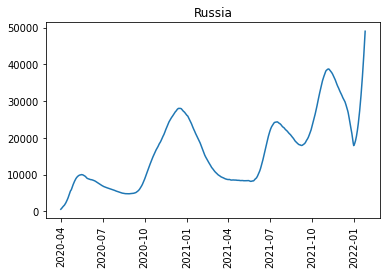

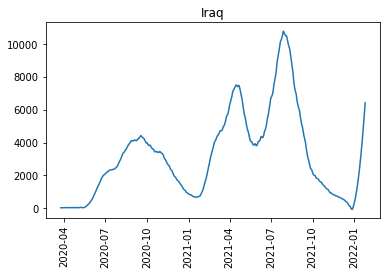

In [ ]:
get_plot("Russia", "Iraq")

In [ ]:
# import itertools

# delim = ';'
# result = dict()
# with open("graph.csv", "w") as f:
#     f.write(f"Country1{delim}Country2{delim}Lag{delim}Degree_of_certainty\n")
#     for coutries_pair in itertools.combinations(countries, 2):
#         c_one, c_two = coutries_pair
#         c1 = get_new_cases(gr, c_one)
#         c2 = get_new_cases(gr, c_two)
#         values = []
#         for i in range(-100, 100, 1):
#             values.append((c1.shift(i).corr(c2), i))

        
#         r = max(values, key=lambda x: x[0])
#         f.write(f"{c_one}{delim}{c_two}{delim}{r[1]}{delim}{r[0]}\n")

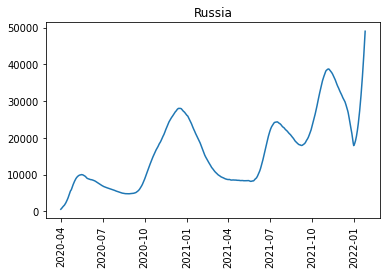

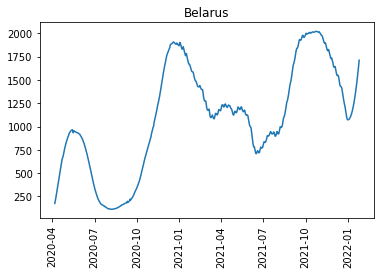

In [ ]:
get_plot("Russia", "Belarus")

<h1>Предикт (модель)</h1>
<ol>
    <li>Для предикта используем последнюю неделю по заражению в данной конкретной стране</li>
    <li>Так же используем максимально похожие страны (пусть будет 25 стран) для взятия "степени крутости" на конкретный день</li>
    <li>Возьмём численную производную ещё и по той неделе, которую анализируем.</li>
</ol>

In [ ]:
# (5 производных на момент ) (7 предыдущих дней новые кейсы) -> следующий день
def get_derivatives(df, graph_data, top_n=5):
    """Вернём производные топ 5ти похожих стран, которые идут до текущей страны"""
    derivatives = []
    for i, (country, day_ago, conf) in enumerate(filter(lambda x: x[1] < 0, graph_data)):
        if i + 1 == top_n:
            break
        
        country_data = df[df["Country_Region"] == country].shift(day_ago)["New_Cases"].iloc[:2].to_numpy()
        derivative = country_data[1] - country_data[0]  # численная производная, единица времени = день
        # Если нан - пусть производная будет единицей
        if not derivative:
            derivative = 1
        
        derivatives.append(derivative)
        
    return derivatives

<h1>Предикт - бейзлайн</h1>

In [ ]:
def get_predict(df, predict_country, graph_data) -> int:
    """Вернёт цифирь, которая предсказывает заболеваемость для конкретной страны"""
    def get_mean(d, c, shift=0, deriv=False):
        """Взятие среднего за 7 дней периода, на который похожа predict_country страна в данный момент"""
        d_country = d[d["Country_Region"] == c].copy()
        new_cases = (d_country["Confirmed"] - d_country["Confirmed"].shift(1)).dropna()
        all_cases = d_country["Confirmed"].iloc[-1]
        if shift != 0:
            seven_days_mean = new_cases.iloc[shift-7:shift].to_numpy().mean()
        else:
            seven_days_mean = new_cases.iloc[-7:].to_numpy().mean()

        if seven_days_mean != seven_days_mean:
            return 0, all_cases
        if deriv:
            # Возвращаем коэффициент, который показывает во сколько раз растёт заболеваемость
            return new_cases.iloc[-1] / new_cases.iloc[-2], seven_days_mean, all_cases
        else:
            return seven_days_mean, all_cases

    d, mean, all_cases = get_mean(df, predict_country, deriv=True)

    result = 0
    weights = 0
    for country, lag, weight in graph_data:
        current_mean, current_cases = get_mean(df, country, lag)
        # Масштабируем число заражённых под данную страну
        coef = all_cases / current_cases
        # Берём коэффициент, на которым будем домножать
        current_mean = current_mean * coef
        # Суммируем
        weights += weight
        result += current_mean * weight

    return int(result / weights * d)

In [ ]:
get_predict(gr, "Russia", filter_results(result, "Russia"))

34092

In [ ]:
filter_results(result, "Russia")[:5]

[('Georgia', -4, 0.8675839578926566),
 ('Uzbekistan', -95, 0.839889541851789),
 ('Iraq', -99, 0.8306987588686917),
 ('Lithuania', -7, 0.8123382645789066),
 ('Venezuela', -100, 0.8022491538999177)]

In [ ]:
r = gr[gr["Country_Region"] == "Russia"].copy()
r["New_Cases"] = (r["Confirmed"] - r["Confirmed"].shift(1)).dropna()
r.to_csv("russia_data.csv")